Deny Andriana

Membuat Model NLP dengan TensorFlow-----Menentukan Genre Movie Berdasarkan sinopsis

Dataset Movie Genre Data ---- Link : kaggle datasets download -d lokkagle/movie-genre-data

In [154]:
# install kaggle
!pip install -q kaggle

In [155]:
#library
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import re
from sklearn.model_selection import train_test_split

In [156]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"enkei0107","key":"86678fa772f067d6e189be9ee711580f"}'}

In [157]:
# buat directory 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [158]:
#download dataset spotify dari kaggle
!kaggle datasets download -d lokkagle/movie-genre-data

  0% 0.00/9.46M [00:00<?, ?B/s]
100% 9.46M/9.46M [00:00<00:00, 250MB/s]


In [182]:
#extract dataset
!mkdir movie-dataset
!unzip movie-genre-data.zip -d movie-dataset
!ls movie-dataset

Archive:  movie-genre-data.zip
  inflating: movie-dataset/kaggle_movie_train.csv  
kaggle_movie_train.csv


In [183]:
#load dataset dari file dataset yang telah di extract
import pandas as pd
df = pd.read_csv('movie-dataset/kaggle_movie_train.csv')
df.head()

id                                               text     genre
0   0  eady dead, maybe even wishing he was. INT. 2ND...  thriller
1   2  t, summa cum laude and all. And I'm about to l...    comedy
2   3   up Come, I have a surprise.... She takes him ...     drama
3   4  ded by the two detectives. INT. JEFF'S APARTME...  thriller
4   5  nd dismounts, just as the other children reach...     drama

In [184]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

In [185]:
# Menghapus tanda baca
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
df = df.drop(['id', 'text'], axis=1)
df.head()

genre                                               Text
0  thriller  eady dead maybe even wishing he was INT 2ND FL...
1    comedy  t summa cum laude and all And I m about to lau...
2     drama   up Come I have a surprise She takes him by th...
3  thriller  ded by the two detectives INT JEFF S APARTMENT...
4     drama  nd dismounts just as the other children reach ...

In [186]:
# Mengecek nilai kosong / nan
df.isnull().values.any()

False

In [187]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

Text  action  adventure  \
0  eady dead maybe even wishing he was INT 2ND FL...       0          0   
1  t summa cum laude and all And I m about to lau...       0          0   
2   up Come I have a surprise She takes him by th...       0          0   
3  ded by the two detectives INT JEFF S APARTMENT...       0          0   
4  nd dismounts just as the other children reach ...       0          0   

   comedy  drama  horror  other  romance  sci-fi  thriller  
0       0      0       0      0        0       0         1  
1       1      0       0      0        0       0         0  
2       0      1       0      0        0       0         0  
3       0      0       0      0        0       0         1  
4       0      1       0      0        0       0         0

In [188]:
# Mengubah tipe data menjadi str dan numpy array 
text = df_genre['Text'].astype(str)
label = df_genre[['action','adventure', 'comedy','drama','horror','other','sci-fi','thriller']].values

In [189]:
#membagi dataset menjadi 2 yaitu train (80%) dan validasi (20%)
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

In [190]:
# tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [191]:
#membuat model ditambah dengan Embedding dan LTSM
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

In [192]:
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [193]:
#membuat fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\n Akurasi training sekarang telah mencapai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [194]:
num_epochs = 25
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/25
565/565 - 95s - loss: 1.4293 - accuracy: 0.3958 - val_loss: 1.1884 - val_accuracy: 0.4624 - 95s/epoch - 168ms/step
Epoch 2/25
565/565 - 77s - loss: 1.1220 - accuracy: 0.4702 - val_loss: 1.0826 - val_accuracy: 0.4883 - 77s/epoch - 136ms/step
Epoch 3/25
565/565 - 77s - loss: 1.0359 - accuracy: 0.4882 - val_loss: 1.0986 - val_accuracy: 0.4934 - 77s/epoch - 136ms/step
Epoch 4/25
565/565 - 78s - loss: 0.9699 - accuracy: 0.5117 - val_loss: 1.0400 - val_accuracy: 0.5097 - 78s/epoch - 139ms/step
Epoch 5/25
565/565 - 77s - loss: 0.8151 - accuracy: 0.6353 - val_loss: 0.9042 - val_accuracy: 0.7095 - 77s/epoch - 136ms/step
Epoch 6/25
565/565 - 77s - loss: 0.5896 - accuracy: 0.7808 - val_loss: 0.8111 - val_accuracy: 0.7192 - 77s/epoch - 136ms/step
Epoch 7/25
565/565 - 79s - loss: 0.4977 - accuracy: 0.8260 - val_loss: 0.7546 - val_accuracy: 0.7730 - 79s/epoch - 140ms/step
Epoch 8/25
565/565 - 77s - loss: 0.4082 - accuracy: 0.8581 - val_loss: 0.7010 - val_accuracy: 0.7876 - 77s/epoch - 136

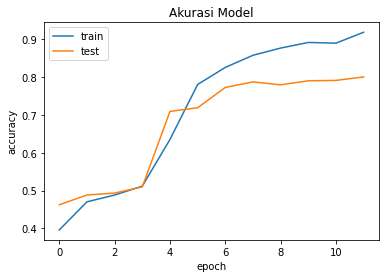

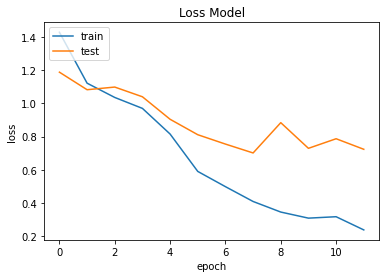

In [195]:
# menampilkan visualisasi plot
import matplotlib.pyplot as plt

#Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()